# Hab Dishab Dopamine Analysis

Plotting the DA associated with different DA metrics (Peak, Mean)
- Plot the peak DA during the first investigation (With and without mice identity)
- Plot the Average peak DA across multiple investigations

In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment
from bouts_extension import *

In [2]:
# NAc: #15616F
# mPFC: #FFAF00

nac_experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\nac"
nac_csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\nac_csvs"
nac_color = '#15616F'

mpfc_experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\mpfc"
mpfc_csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\mpfc_csvs"
mpfc_color = '#FFAF00'

# experiment_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Hab Dishab/all/nac"
# csv_base_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Hab Dishab/all_csvs/nac_csvs"
# brain_region = '#15616F'

# experiment_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Hab Dishab/all/mpfc"
# csv_base_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Hab Dishab/all_csvs/mpfc_csvs"
# brain_region = '#FFAF00'

save_images = False

In [3]:
bout_definitions = [
    {'prefix': 's1', 'introduced': 's1_Introduced', 'removed': 's1_Removed'},
    {'prefix': 's2', 'introduced': 's2_Introduced', 'removed': 's2_Removed'}
]


In [4]:
# groups csv + experiment data into one variable
nac_exp = Experiment(nac_experiment_path, nac_csv_base_path)

mpfc_exp = Experiment(mpfc_experiment_path, mpfc_csv_base_path)

# # batch process the data, removing the specified time segments for subjects
# nac_exp.batch_process_exponential()
# mpfc_exp.batch_process_exponential()

nac_exp.default_batch_process()
mpfc_exp.default_batch_process()

Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\nac\n6-240821-100116\Notes.txt
read from t=0s to t=1335.06s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\nac\n7-240821-114717\Notes.txt
read from t=0s to t=1309.86s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\nac\nn1-250115-052028\Notes.txt
read from t=0s to t=1351.05s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\nac\nn2-250115-054951\Notes.txt
read from t=0s to t=1349.96s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\nac\nn3-250115-064154\Notes.txt
read from t=0s to t=1377.67s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Hab_Dishab\All\nac\nn4

In [24]:
nac_exp.trials['n6-240821-100116'].zscore

array([1.02726982, 1.00988492, 0.98398811, ..., 0.13359906, 0.15385014,
       0.17008869])

### Peak standard z-score

In [5]:
nac_exp.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = True)

mpfc_exp.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = True)

# total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
# print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")
# Proceed with DA metric computation after all files are processed
nac_exp.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, #otal_avg_bout_duration
                                  mode='standard')

mpfc_exp.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, #otal_avg_bout_duration
                                  mode='standard')

Processing behaviors for n6-240821-100116...
Processing behaviors for n7-240821-114717...
Processing behaviors for nn1-250115-052028...
Processing behaviors for nn2-250115-054951...
Processing behaviors for nn3-250115-064154...
Processing behaviors for nn4-250115-072812...
Processing behaviors for nn5-250114-083827...
Processing behaviors for nn6-250114-093117...
Processing behaviors for nn7-250114-100133...
Processing behaviors for nn8-250114-103839...
Processing behaviors for p1-240516-064158...
Processing behaviors for p2-240516-071921...
Processing behaviors for p3-240516-075659...
Processing behaviors for p5-240821-092649...
Processing behaviors for p6-240821-103616...
Processing behaviors for p7-240821-111323...
Processing behaviors for p8-240821-121933...
Processing behaviors for pp1-250115-080205...
Processing behaviors for pp2-250115-083739...
Processing behaviors for pp3-250115-091306...
Processing behaviors for pp4-250115-094555...
Processing behaviors for pp5-250114-053943.

In [6]:
nac_exp_da_dict = get_trial_dataframes(nac_exp)
mpfc_exp_da_dict = get_trial_dataframes(mpfc_exp)

In [ ]:
# desired_bouts = ['s1_1', 's1_2', 's1_3', 's1_4', 's1_5', 's2_1']

desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']

nac_da_metadata_df = create_da_metrics_dataframe(nac_exp_da_dict, behavior="Investigation", desired_bouts=desired_bouts)

mpfc_da_metadata_df = create_da_metrics_dataframe(mpfc_exp_da_dict, behavior="Investigation", desired_bouts=desired_bouts)

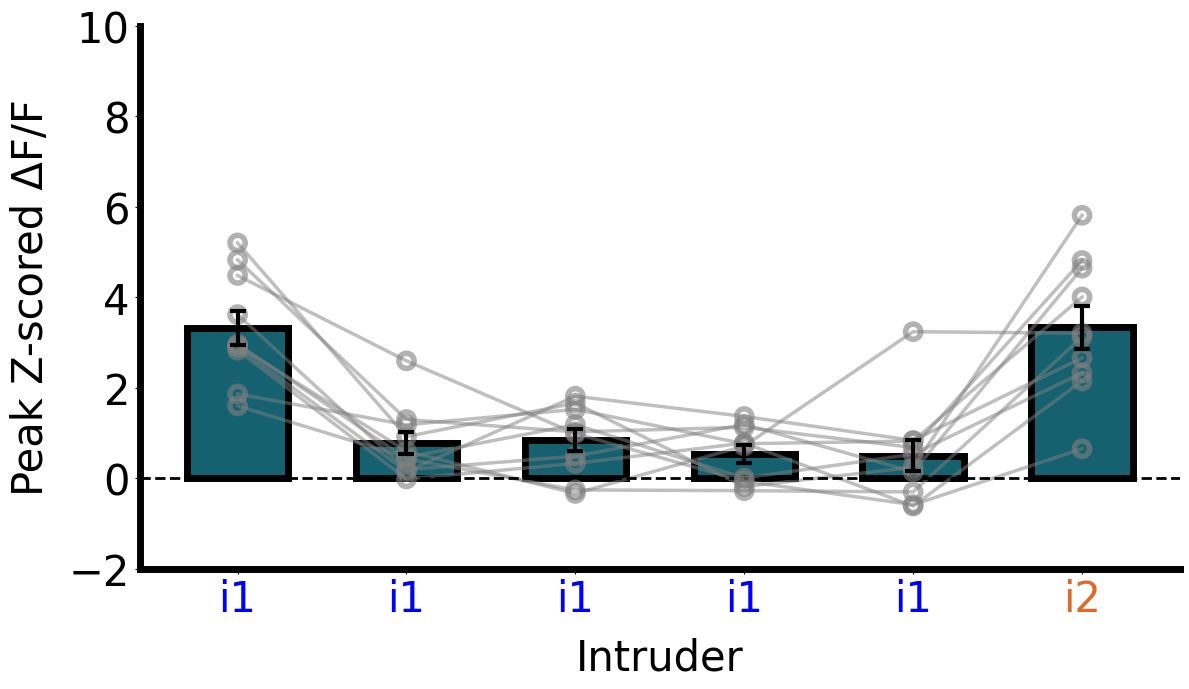


Paired t-test results:
  comparison  n  t_stat  p_value  cohen_d
s1_1 vs s1_2 10  7.3311   0.0000   2.3183
s1_1 vs s1_3 10  5.8352   0.0002   1.8453
s1_1 vs s1_4 10  6.2682   0.0001   1.9822
s1_1 vs s1_5 10  4.9761   0.0008   1.5736
s1_1 vs s2_1 10 -0.0330   0.9744  -0.0104
s1_2 vs s1_3 10 -0.2038   0.8431  -0.0644
s1_2 vs s1_4 10  0.6607   0.5254   0.2089
s1_2 vs s1_5 10  0.6176   0.5522   0.1953
s1_2 vs s2_1 10 -4.3627   0.0018  -1.3796
s1_3 vs s1_4 10  1.0328   0.3287   0.3266
s1_3 vs s1_5 10  0.7431   0.4764   0.2350
s1_3 vs s2_1 10 -5.0426   0.0007  -1.5946
s1_4 vs s1_5 10  0.1227   0.9051   0.0388
s1_4 vs s2_1 10 -5.7962   0.0003  -1.8329
s1_5 vs s2_1 10 -5.3556   0.0005  -1.6936


In [47]:
# Average Bout Duration Across Bouts
nac_pivot_df, nac_stats_df = plot_behavior_across_bouts_no_identities(
    metadata_df=nac_da_metadata_df,
    y_col="Max Peak",
    behavior="Investigation",
    title=None,
    xlabel="Intruder",
    ylabel="Peak Z-scored ΔF/F",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(-2, 9),
    bar_color=nac_color,
    yticks_increment=2,
    figsize=(12,7),
    pad_inches=0.1,
    save=None,
    save_name=r"Hab_Dishab_Plots\mPFC_DA\mPFC_C1_3_Peak"
)

In [9]:
bon_results = apply_multiple_comparisons(
    nac_stats_df,
    method='holm',
    alpha=0.05,
    comparisons=["s1-1 vs s1-2", "s1-5 vs s2-1"]
)


Holm‐corrected results (α=0.05):
  comparison  p_value  p_adj sig
s1-1 vs s1-2      NaN    NaN   ✔
s1-5 vs s2-1      NaN    NaN   ✔


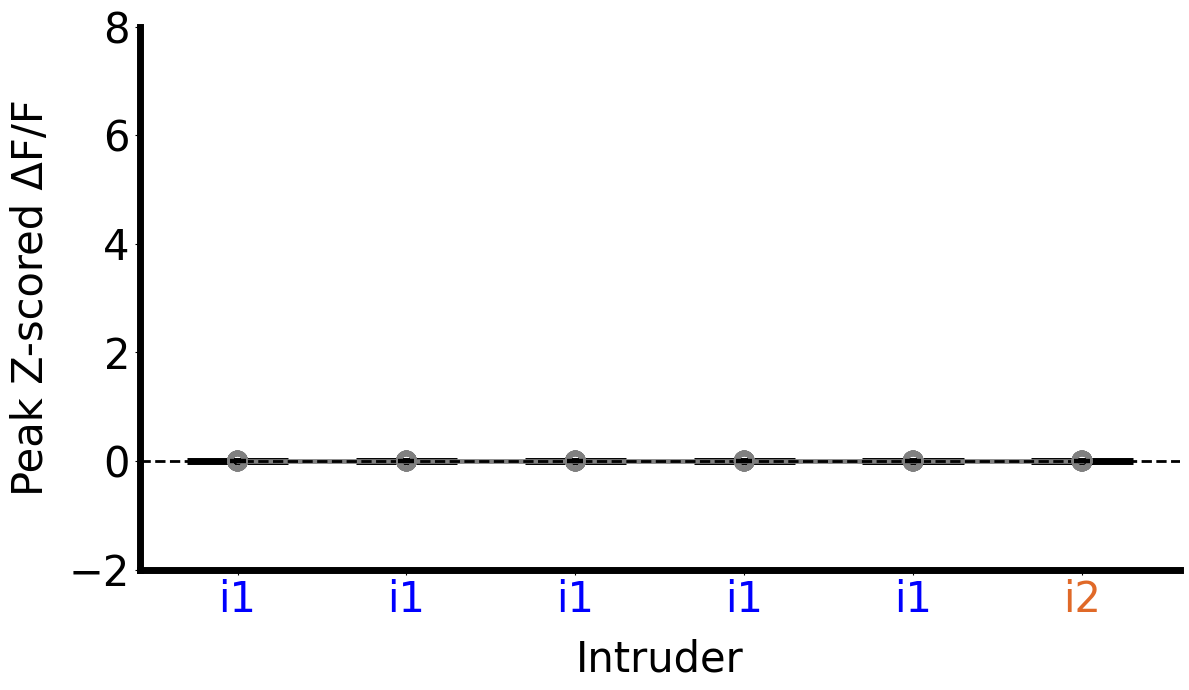


Paired t-test results:
  comparison  n  t_stat  p_value  cohen_d
s1-1 vs s1-2 15     NaN      NaN      NaN
s1-1 vs s1-3 15     NaN      NaN      NaN
s1-1 vs s1-4 15     NaN      NaN      NaN
s1-1 vs s1-5 15     NaN      NaN      NaN
s1-1 vs s2-1 15     NaN      NaN      NaN
s1-2 vs s1-3 15     NaN      NaN      NaN
s1-2 vs s1-4 15     NaN      NaN      NaN
s1-2 vs s1-5 15     NaN      NaN      NaN
s1-2 vs s2-1 15     NaN      NaN      NaN
s1-3 vs s1-4 15     NaN      NaN      NaN
s1-3 vs s1-5 15     NaN      NaN      NaN
s1-3 vs s2-1 15     NaN      NaN      NaN
s1-4 vs s1-5 15     NaN      NaN      NaN
s1-4 vs s2-1 15     NaN      NaN      NaN
s1-5 vs s2-1 15     NaN      NaN      NaN


In [10]:
# Average Bout Duration Across Bouts
mpfc_pivot_df, mpfc_stats_df = plot_behavior_across_bouts_no_identities(
    metadata_df=mpfc_da_metadata_df,
    y_col="Max Peak",
    behavior="Investigation",
    title=None,
    xlabel="Intruder",
    ylabel="Peak Z-scored ΔF/F",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(-2, 8),
    bar_color=mpfc_color,
    yticks_increment=2,
    figsize=(12,7),
    pad_inches=0.1,
    save=None,
    save_name=r"Hab_Dishab_Plots\mPFC_DA\mPFC_C1_3_Peak"
)

In [11]:
bon_results = apply_multiple_comparisons(
    mpfc_stats_df,
    method='holm',
    alpha=0.05,
    comparisons=["s1-1 vs s1-2", "s1-5 vs s2-1"]
)


Holm‐corrected results (α=0.05):
  comparison  p_value  p_adj sig
s1-1 vs s1-2      NaN    NaN   ✔
s1-5 vs s2-1      NaN    NaN   ✔


In [12]:
# from statsmodels.stats.multitest import multipletests

# # your two raw p‐values:
# comparisons = ["s1-1 vs s1-2", "s1-5 vs s2-1"]
# raw_p     = [0.0076,      0.003]

# # Holm–Bonferroni
# reject, p_adj, _, _ = multipletests(raw_p, alpha=0.05, method='holm')

# for comp, p0, p1, rej in zip(comparisons, raw_p, p_adj, reject):
#     sig = "✓" if rej else "n.s."
#     print(f"{comp}: raw p = {p0:.4f}, Holm-adj p = {p1:.4f} → {sig}")


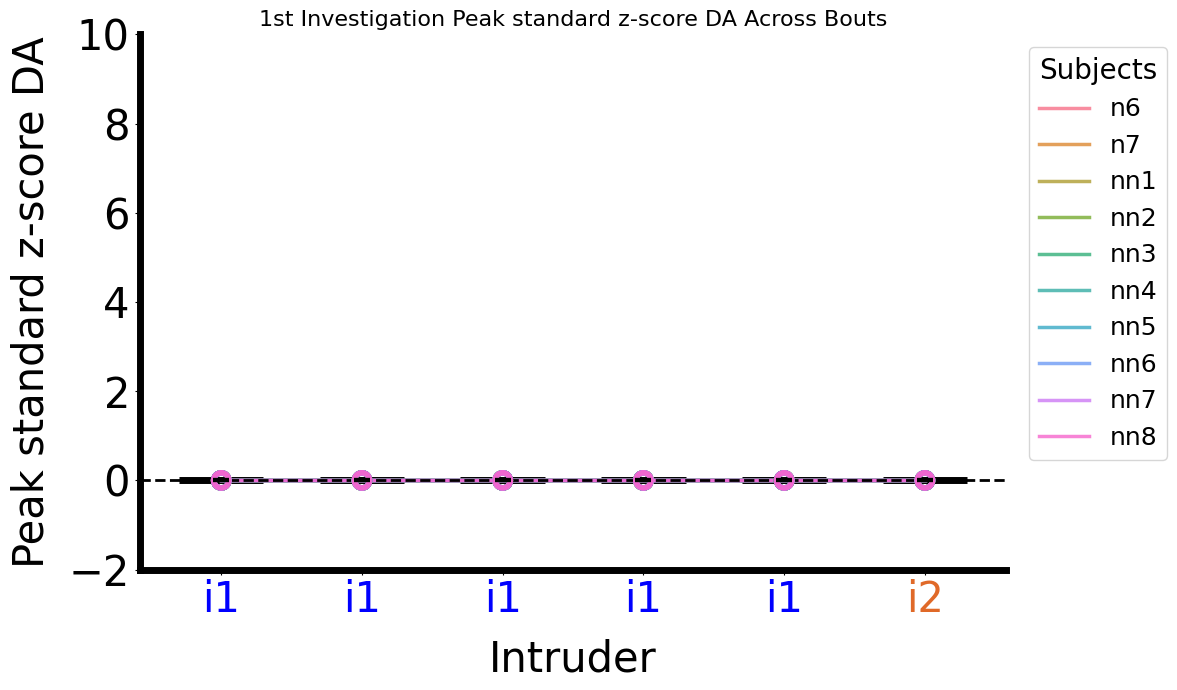

In [13]:
# Average Bout Duration Across Bouts
plot_behavior_across_bouts_with_identities(
    metadata_df=nac_da_metadata_df,
    y_col="Max Peak",
    behavior="Investigation",
    title="1st Investigation Peak standard z-score DA Across Bouts",
    xlabel="Intruder",
    ylabel="Peak standard z-score DA",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(-2, 10),
    bar_color=nac_color,
    yticks_increment=2,
    figsize=(12,7),
    pad_inches=0.1,
    save=None,
    save_name=r"Hab_Dishab_Plots\mPFC_DA\mPFC_Peak_Across_Bouts_WIDENTITIES.png"
)

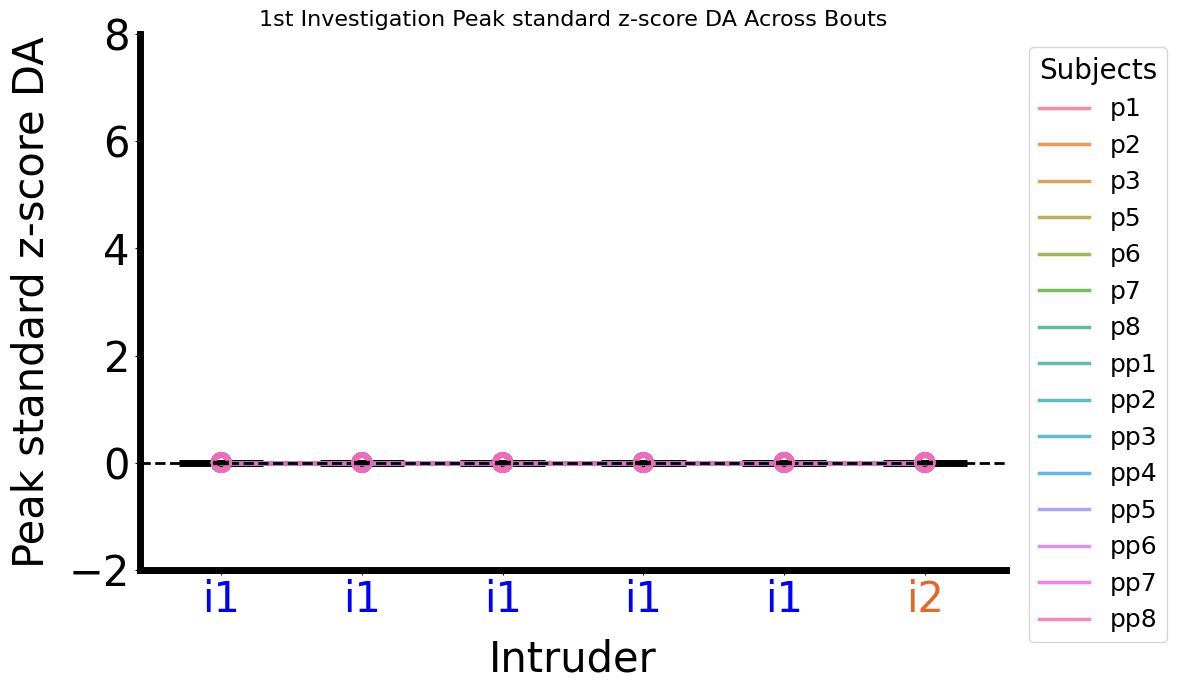

In [14]:
# Average Bout Duration Across Bouts
plot_behavior_across_bouts_with_identities(
    metadata_df=mpfc_da_metadata_df,
    y_col="Max Peak",
    behavior="Investigation",
    title="1st Investigation Peak standard z-score DA Across Bouts",
    xlabel="Intruder",
    ylabel="Peak standard z-score DA",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(-2, 8),
    bar_color=mpfc_color,
    yticks_increment=2,
    figsize=(12,7),
    pad_inches=0.1,
    save=None,
    save_name=r"Hab_Dishab_Plots\mPFC_DA\mPFC_Peak_Across_Bouts_WIDENTITIES.png"
)

Restart because not only looking at first investigation any longer

In [15]:
nac_exp.reset_all_behaviors()
nac_exp.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = False)

# total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
# print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")
# Proceed with DA metric computation after all files are processed
nac_exp.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, # total_avg_bout_duration 
                                  mode='standard')

mpfc_exp.reset_all_behaviors()
mpfc_exp.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = False)

# total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
# print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")
# Proceed with DA metric computation after all files are processed
mpfc_exp.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, # total_avg_bout_duration 
                                  mode='standard')

Processing behaviors for n6-240821-100116...
Processing behaviors for n7-240821-114717...
Processing behaviors for nn1-250115-052028...
Processing behaviors for nn2-250115-054951...
Processing behaviors for nn3-250115-064154...
Processing behaviors for nn4-250115-072812...
Processing behaviors for nn5-250114-083827...
Processing behaviors for nn6-250114-093117...
Processing behaviors for nn7-250114-100133...
Processing behaviors for nn8-250114-103839...
Computing DA metrics for n6-240821-100116 ...
Computing DA metrics for n7-240821-114717 ...
Computing DA metrics for nn1-250115-052028 ...
Computing DA metrics for nn2-250115-054951 ...
Computing DA metrics for nn3-250115-064154 ...
Computing DA metrics for nn4-250115-072812 ...
Computing DA metrics for nn5-250114-083827 ...
Computing DA metrics for nn6-250114-093117 ...
Computing DA metrics for nn7-250114-100133 ...
Computing DA metrics for nn8-250114-103839 ...
Processing behaviors for p1-240516-064158...
Processing behaviors for p2-2

In [16]:
nac_exp_da_dict = get_trial_dataframes(nac_exp)
mpfc_exp_da_dict = get_trial_dataframes(mpfc_exp)

desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']

IMPORTANT NOTE OF FUNCTION: the reason why there might be a discrepancy in the number of mice displayed is because if a subject doesn't have x subsequent investigations, then the mouse is not included

In [17]:
agg_df = plot_peak_for_subsequent_behaviors(
    nac_exp_da_dict,
    behavior="Investigation",
    selected_bouts=["s1-1", "s2-1"],
    n_subsequent_behaviors=5,
    peak_col="Max Peak",
    metric_type='decay', 
    xlabel="Investigation Index",
    ylabel="Average Peak ΔF/F",
    ylim=(0, 7),
    ytick_increment=2,
    plot_title="",
    save = False,
    save_path=r"Hab_Dishab_Plots\mPFC_DA\peaks_for_subsequent_behaviors.png" 
)

No data left after filtering for bouts and behavior. Nothing to plot.


In [18]:
agg_df = plot_peak_for_subsequent_behaviors(
    mpfc_exp_da_dict,
    behavior="Investigation",
    selected_bouts=["s1-1", "s2-1"],
    n_subsequent_behaviors=5,
    peak_col="Max Peak",
    metric_type='decay', 
    xlabel="Investigation Index",
    ylabel="Average Peak ΔF/F",
    ylim=(0, 3),
    ytick_increment=2,
    plot_title="",
    save = False,
    save_path=r"Hab_Dishab_Plots\mPFC_DA\peaks_for_subsequent_behaviors.png" 
)

No data left after filtering for bouts and behavior. Nothing to plot.


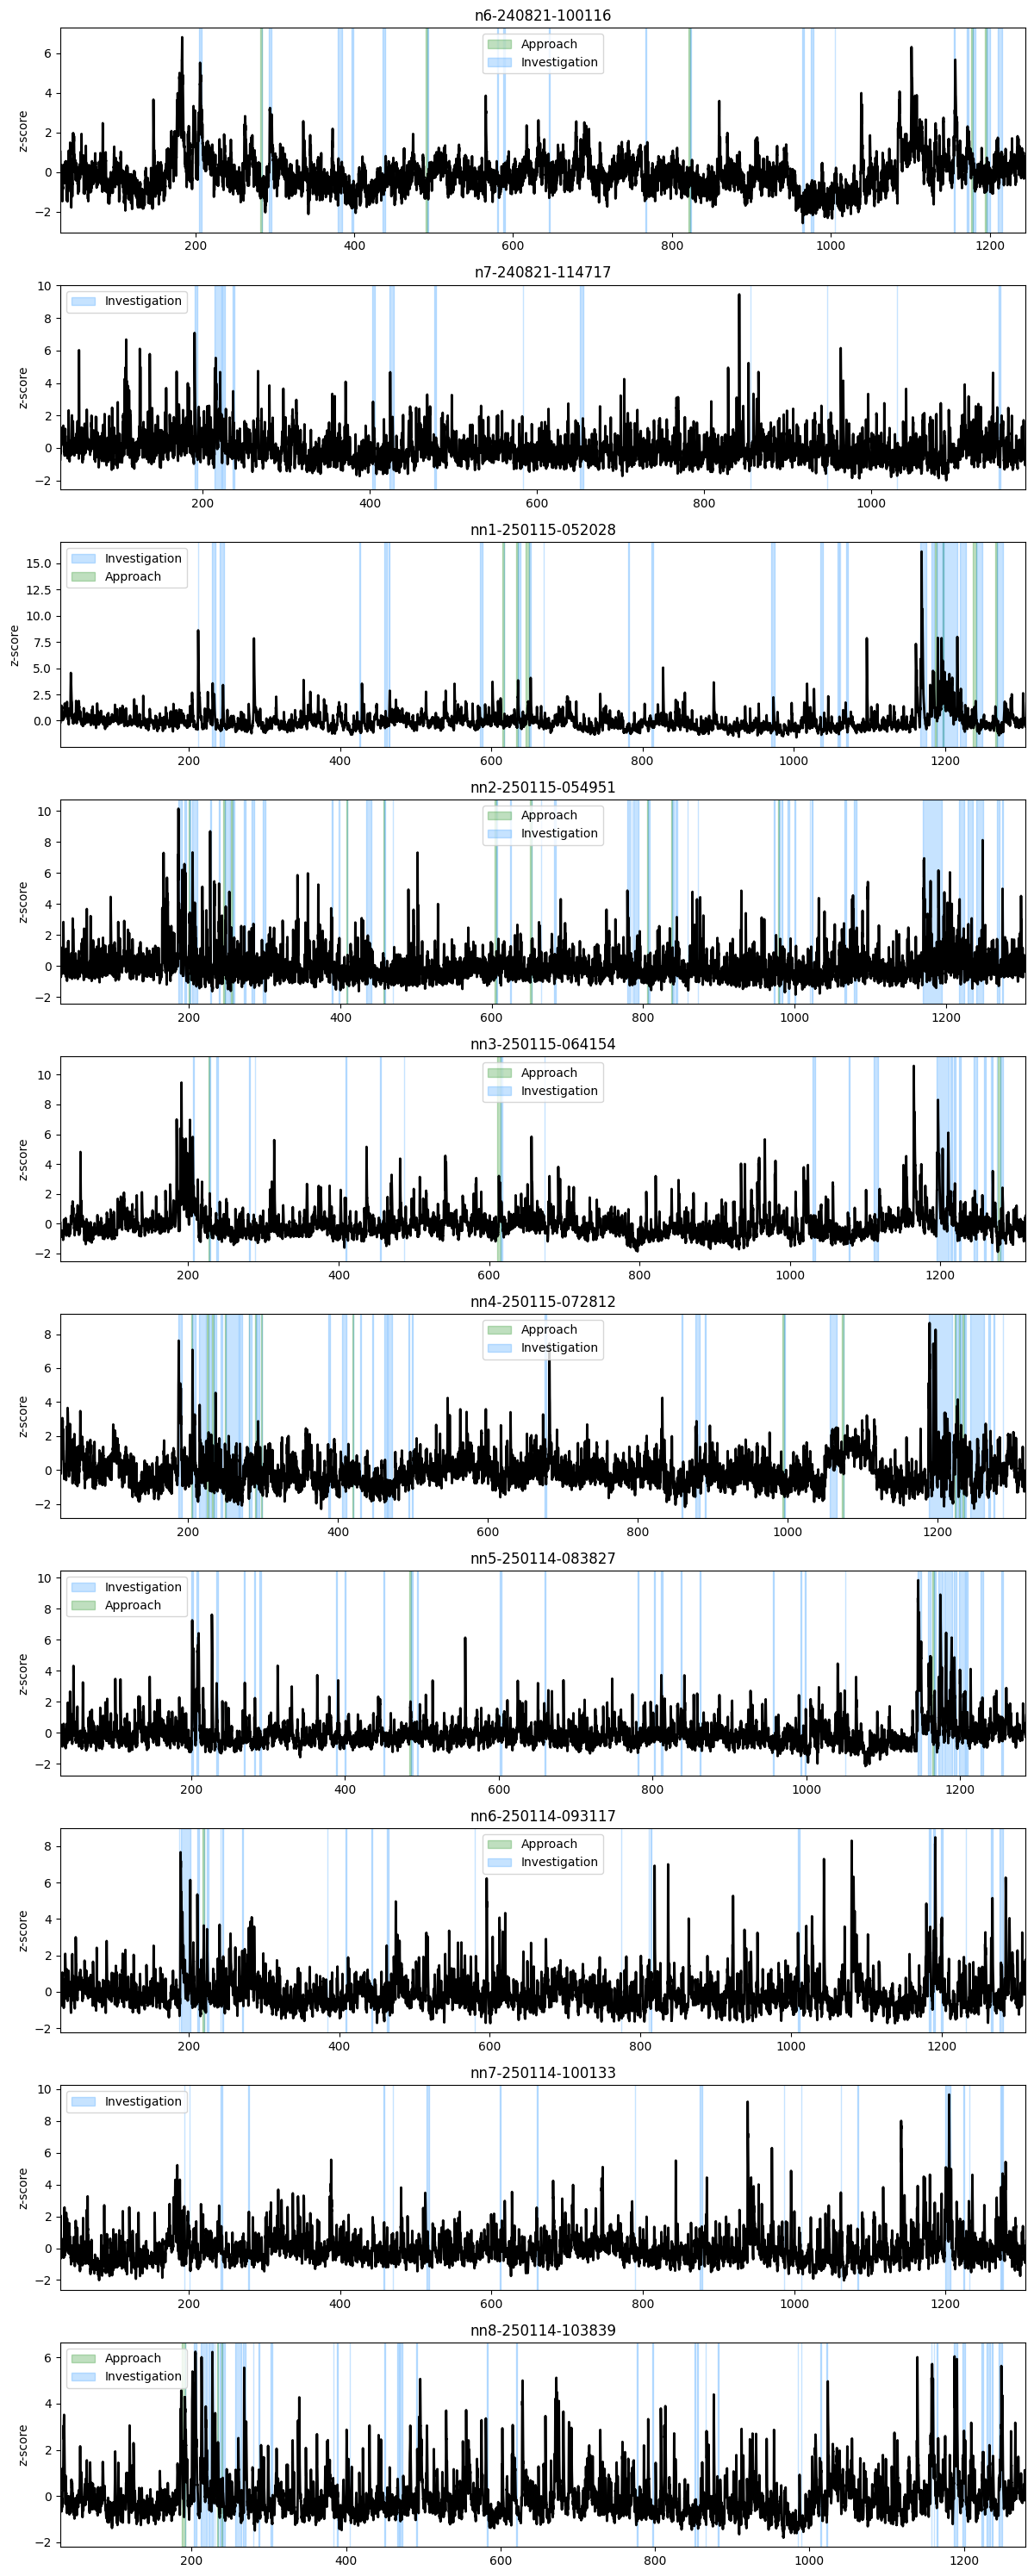

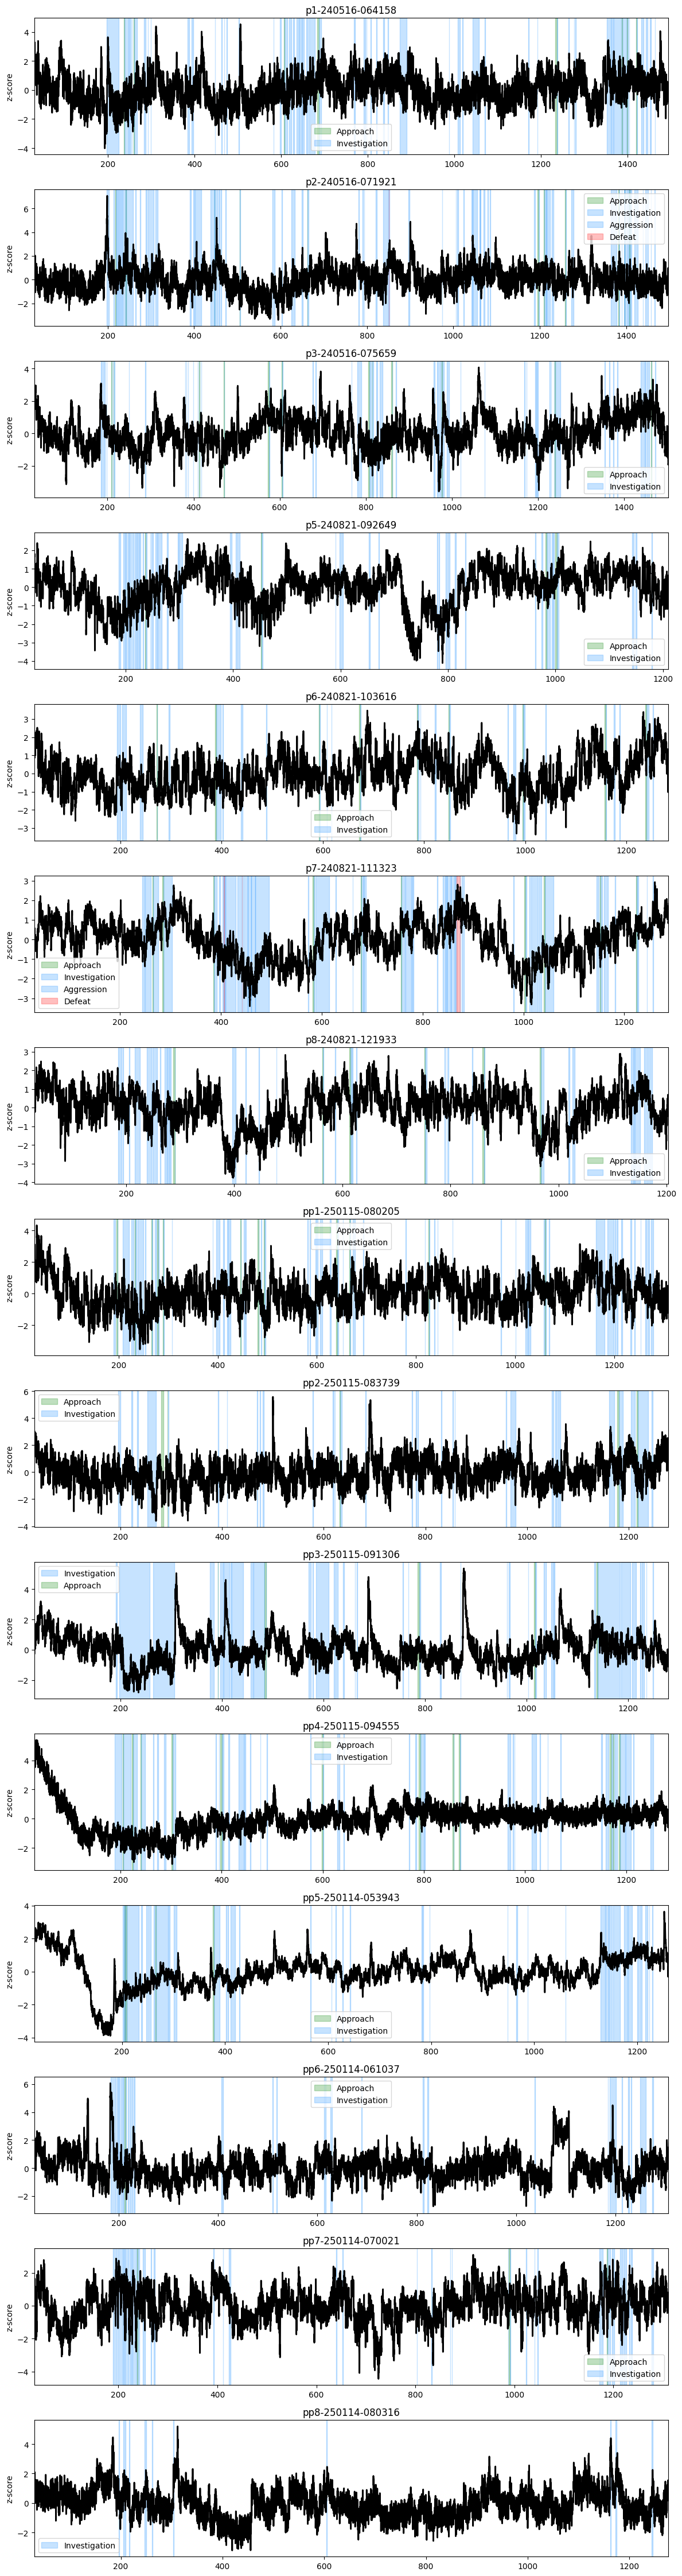

In [19]:
nac_exp.plot_all_traces(ylim=None)
mpfc_exp.plot_all_traces(ylim=None)